# Road sign generation

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip trafic_32.zip
data_path = 'trafic_32'

In [5]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

Number of images in training dataset: 31367
Number of images in validation dataset: 3920
Number of images in test dataset: 3922


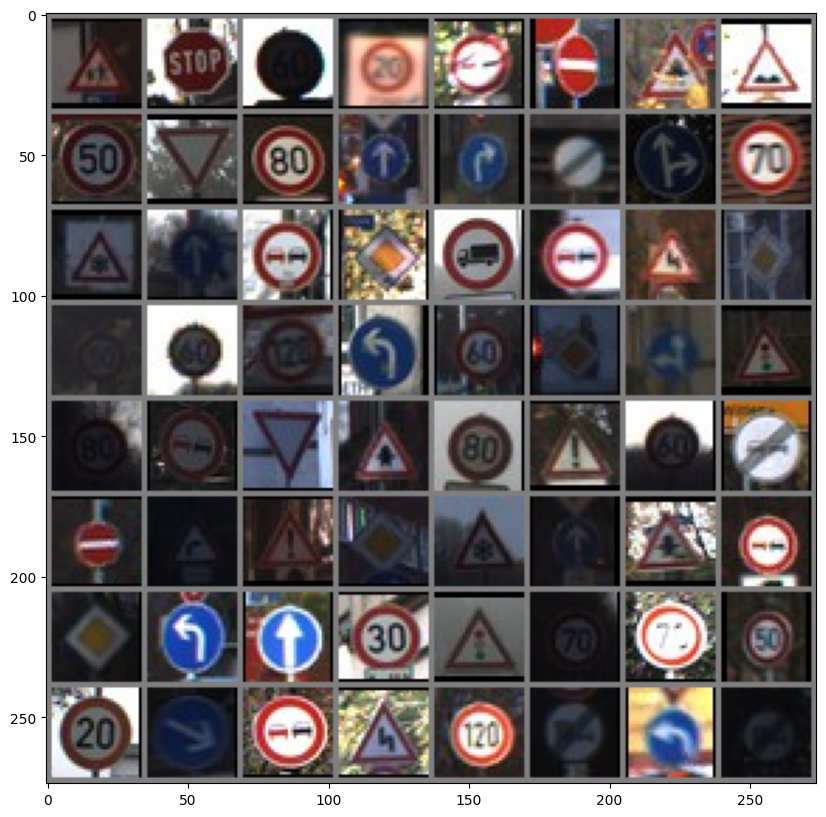

['00028', '00014', '00003', '00000', '00009', '00017', '00011', '00022', '00002', '00013', '00005', '00035', '00033', '00032', '00036', '00004', '00030', '00035', '00009', '00012', '00016', '00009', '00021', '00012', '00002', '00003', '00008', '00034', '00003', '00012', '00037', '00026', '00005', '00009', '00013', '00011', '00005', '00018', '00003', '00041', '00017', '00020', '00018', '00012', '00030', '00035', '00011', '00009', '00012', '00034', '00035', '00001', '00026', '00004', '00004', '00002', '00000', '00038', '00009', '00021', '00008', '00042', '00034', '00042']


In [6]:
plt.figure(figsize = (20,10))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(list(dataset.classes[labels[j]] for j in range(batch_size)))

In [7]:
n_classes = len(dataset.classes)
images.size()

torch.Size([64, 3, 32, 32])

## FID

In [8]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, n_classes)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x


    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(32*32*3, 256).to(device)

In [9]:
# Optimizers
eval_optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
eval_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=eval_optimizer, gamma=0.97)

# loss
eval_criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = eval_criterion(results, targets)

        eval_optimizer.zero_grad()
        loss.backward()
        eval_optimizer.step()

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [10]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [11]:
orig_data = [x[0] for x in list(test_dataset)[:1000]]
orig_data = torch.stack(orig_data)

dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()

## Generative Adversarial Networks


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(4*4*256, 64),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 4*4*256),
            nn.BatchNorm1d(4*4*256),
            nn.ReLU(0.2),
            nn.Unflatten(1, (256, 4, 4)),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(0.2),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),

            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [14]:
# Models
latent_dim = 64

generator = Generator(latent_dim=latent_dim,).to(device)
discriminator = Discriminator().to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [15]:
fixed_noise = torch.randn(16, latent_dim,device=device)

eval_fixed_noise = torch.randn(1000, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.318, discriminator real acc: 0.653
Epoch: 1, discrimiantor fake error: 0.353, discriminator real acc: 0.64
Epoch: 2, discrimiantor fake error: 0.341, discriminator real acc: 0.66
Epoch: 3, discrimiantor fake error: 0.343, discriminator real acc: 0.658
Epoch: 4, discrimiantor fake error: 0.344, discriminator real acc: 0.655
Epoch: 5, discrimiantor fake error: 0.34, discriminator real acc: 0.659
Epoch: 6, discrimiantor fake error: 0.333, discriminator real acc: 0.666
Epoch: 7, discrimiantor fake error: 0.329, discriminator real acc: 0.67
Epoch: 8, discrimiantor fake error: 0.327, discriminator real acc: 0.672
Epoch: 9, discrimiantor fake error: 0.327, discriminator real acc: 0.673


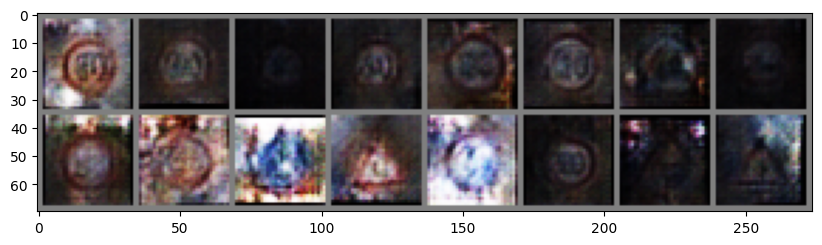

FID: 716.7532920724825
Epoch: 10, discrimiantor fake error: 0.328, discriminator real acc: 0.671
Epoch: 11, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 12, discrimiantor fake error: 0.328, discriminator real acc: 0.671
Epoch: 13, discrimiantor fake error: 0.328, discriminator real acc: 0.671
Epoch: 14, discrimiantor fake error: 0.33, discriminator real acc: 0.669
Epoch: 15, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 16, discrimiantor fake error: 0.332, discriminator real acc: 0.668
Epoch: 17, discrimiantor fake error: 0.332, discriminator real acc: 0.668
Epoch: 18, discrimiantor fake error: 0.332, discriminator real acc: 0.667
Epoch: 19, discrimiantor fake error: 0.334, discriminator real acc: 0.666


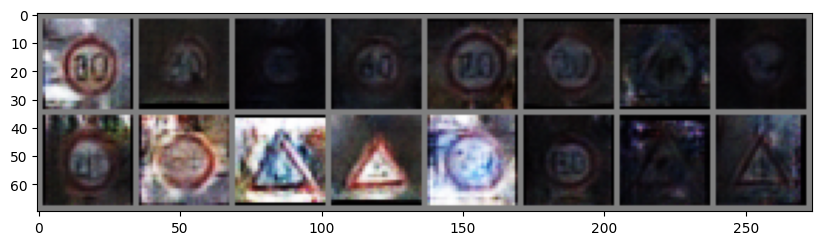

FID: 693.0698811432294
Epoch: 20, discrimiantor fake error: 0.332, discriminator real acc: 0.666
Epoch: 21, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 22, discrimiantor fake error: 0.332, discriminator real acc: 0.667
Epoch: 23, discrimiantor fake error: 0.331, discriminator real acc: 0.668
Epoch: 24, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 25, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 26, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 27, discrimiantor fake error: 0.333, discriminator real acc: 0.666
Epoch: 28, discrimiantor fake error: 0.333, discriminator real acc: 0.666
Epoch: 29, discrimiantor fake error: 0.334, discriminator real acc: 0.666


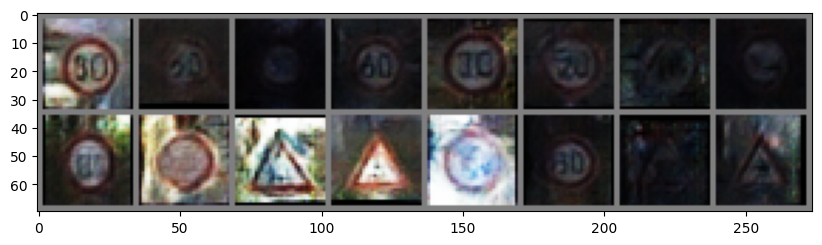

FID: 701.5526790721124
Epoch: 30, discrimiantor fake error: 0.334, discriminator real acc: 0.664
Epoch: 31, discrimiantor fake error: 0.333, discriminator real acc: 0.666
Epoch: 32, discrimiantor fake error: 0.333, discriminator real acc: 0.666
Epoch: 33, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 34, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 35, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 36, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 37, discrimiantor fake error: 0.335, discriminator real acc: 0.665
Epoch: 38, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 39, discrimiantor fake error: 0.336, discriminator real acc: 0.663


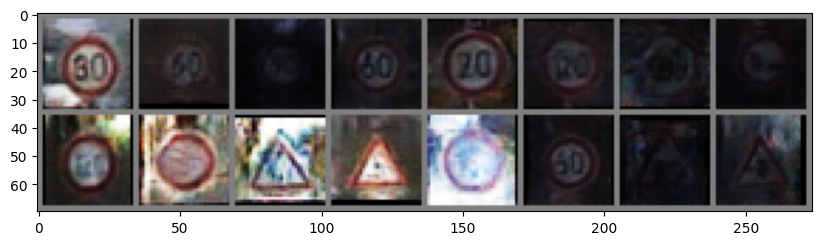

FID: 634.1186271547995
Epoch: 40, discrimiantor fake error: 0.337, discriminator real acc: 0.662
Epoch: 41, discrimiantor fake error: 0.337, discriminator real acc: 0.663
Epoch: 42, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 43, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 44, discrimiantor fake error: 0.337, discriminator real acc: 0.663
Epoch: 45, discrimiantor fake error: 0.336, discriminator real acc: 0.662
Epoch: 46, discrimiantor fake error: 0.337, discriminator real acc: 0.663
Epoch: 47, discrimiantor fake error: 0.337, discriminator real acc: 0.662
Epoch: 48, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 49, discrimiantor fake error: 0.336, discriminator real acc: 0.664


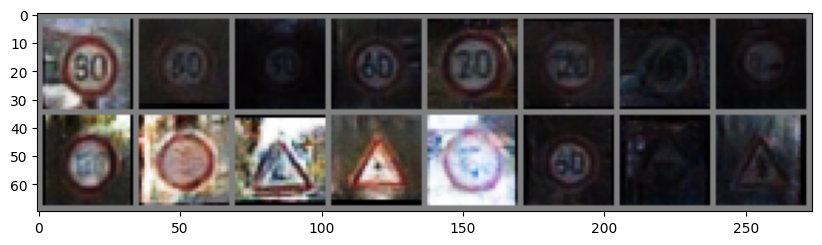

FID: 725.3047167672776
Epoch: 50, discrimiantor fake error: 0.336, discriminator real acc: 0.663
Epoch: 51, discrimiantor fake error: 0.338, discriminator real acc: 0.662
Epoch: 52, discrimiantor fake error: 0.336, discriminator real acc: 0.663
Epoch: 53, discrimiantor fake error: 0.336, discriminator real acc: 0.663
Epoch: 54, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 55, discrimiantor fake error: 0.336, discriminator real acc: 0.663
Epoch: 56, discrimiantor fake error: 0.337, discriminator real acc: 0.663
Epoch: 57, discrimiantor fake error: 0.337, discriminator real acc: 0.663
Epoch: 58, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 59, discrimiantor fake error: 0.336, discriminator real acc: 0.663


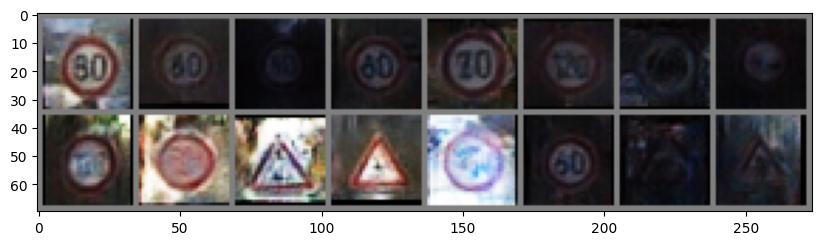

FID: 677.8994889701862
Epoch: 60, discrimiantor fake error: 0.337, discriminator real acc: 0.663
Epoch: 61, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 62, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 63, discrimiantor fake error: 0.337, discriminator real acc: 0.663
Epoch: 64, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 65, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 66, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 67, discrimiantor fake error: 0.336, discriminator real acc: 0.663
Epoch: 68, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 69, discrimiantor fake error: 0.335, discriminator real acc: 0.665


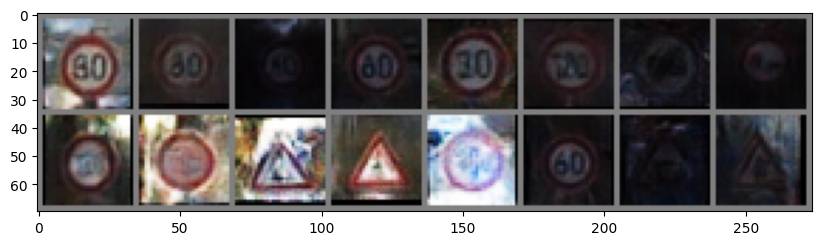

FID: 665.0928608645654
Epoch: 70, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 71, discrimiantor fake error: 0.336, discriminator real acc: 0.664
Epoch: 72, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 73, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 74, discrimiantor fake error: 0.335, discriminator real acc: 0.665
Epoch: 75, discrimiantor fake error: 0.335, discriminator real acc: 0.665
Epoch: 76, discrimiantor fake error: 0.335, discriminator real acc: 0.665
Epoch: 77, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 78, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 79, discrimiantor fake error: 0.335, discriminator real acc: 0.665


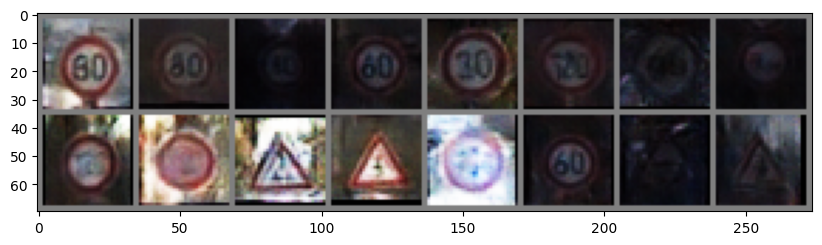

FID: 670.1991537058539
Epoch: 80, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 81, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 82, discrimiantor fake error: 0.335, discriminator real acc: 0.664
Epoch: 83, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 84, discrimiantor fake error: 0.334, discriminator real acc: 0.667
Epoch: 85, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 86, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 87, discrimiantor fake error: 0.333, discriminator real acc: 0.666
Epoch: 88, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 89, discrimiantor fake error: 0.334, discriminator real acc: 0.666


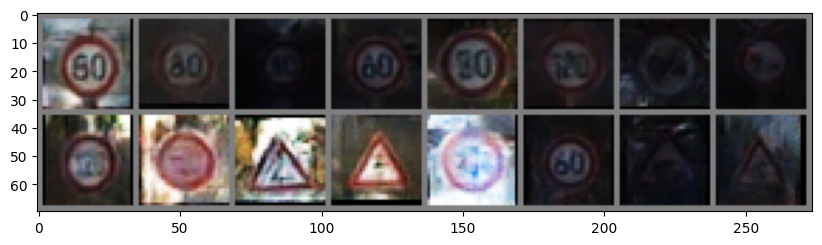

FID: 647.0255628032846
Epoch: 90, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 91, discrimiantor fake error: 0.334, discriminator real acc: 0.665
Epoch: 92, discrimiantor fake error: 0.335, discriminator real acc: 0.665
Epoch: 93, discrimiantor fake error: 0.332, discriminator real acc: 0.668
Epoch: 94, discrimiantor fake error: 0.334, discriminator real acc: 0.666
Epoch: 95, discrimiantor fake error: 0.332, discriminator real acc: 0.667
Epoch: 96, discrimiantor fake error: 0.332, discriminator real acc: 0.668
Epoch: 97, discrimiantor fake error: 0.331, discriminator real acc: 0.668
Epoch: 98, discrimiantor fake error: 0.333, discriminator real acc: 0.666
Epoch: 99, discrimiantor fake error: 0.334, discriminator real acc: 0.667


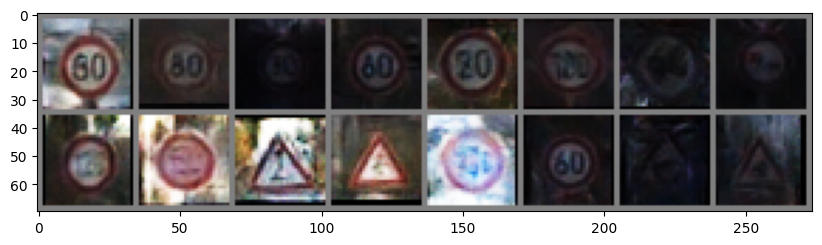

FID: 649.5909764538037
Epoch: 100, discrimiantor fake error: 0.332, discriminator real acc: 0.667
Epoch: 101, discrimiantor fake error: 0.333, discriminator real acc: 0.667
Epoch: 102, discrimiantor fake error: 0.331, discriminator real acc: 0.668
Epoch: 103, discrimiantor fake error: 0.333, discriminator real acc: 0.667
Epoch: 104, discrimiantor fake error: 0.332, discriminator real acc: 0.669
Epoch: 105, discrimiantor fake error: 0.332, discriminator real acc: 0.667
Epoch: 106, discrimiantor fake error: 0.333, discriminator real acc: 0.667
Epoch: 107, discrimiantor fake error: 0.333, discriminator real acc: 0.667
Epoch: 108, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 109, discrimiantor fake error: 0.333, discriminator real acc: 0.667


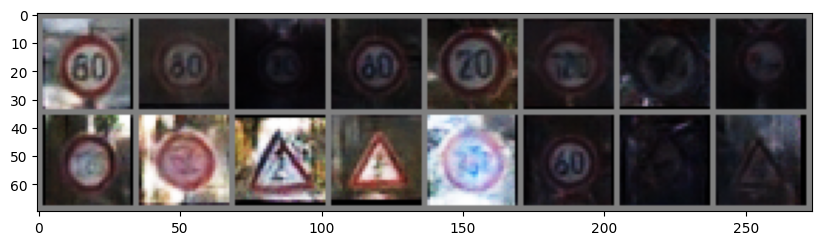

FID: 673.0999530785211
Epoch: 110, discrimiantor fake error: 0.331, discriminator real acc: 0.668
Epoch: 111, discrimiantor fake error: 0.333, discriminator real acc: 0.667
Epoch: 112, discrimiantor fake error: 0.332, discriminator real acc: 0.667
Epoch: 113, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 114, discrimiantor fake error: 0.332, discriminator real acc: 0.668
Epoch: 115, discrimiantor fake error: 0.332, discriminator real acc: 0.668
Epoch: 116, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 117, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 118, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 119, discrimiantor fake error: 0.331, discriminator real acc: 0.669


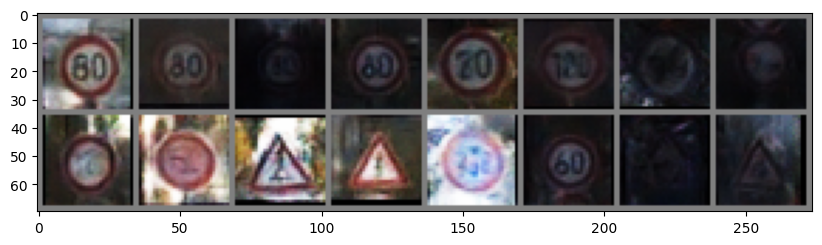

FID: 744.4263988849534
Epoch: 120, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 121, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 122, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 123, discrimiantor fake error: 0.332, discriminator real acc: 0.668
Epoch: 124, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 125, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 126, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 127, discrimiantor fake error: 0.331, discriminator real acc: 0.669
Epoch: 128, discrimiantor fake error: 0.33, discriminator real acc: 0.669
Epoch: 129, discrimiantor fake error: 0.331, discriminator real acc: 0.669


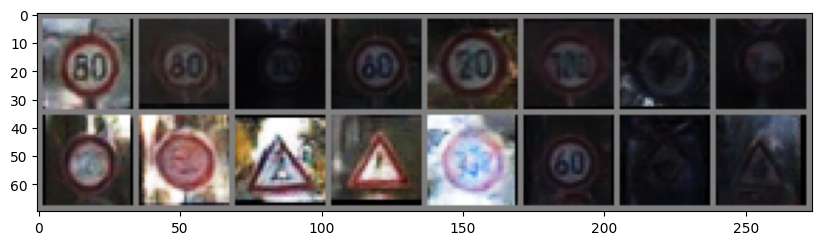

FID: 682.6857732648923
Epoch: 130, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 131, discrimiantor fake error: 0.329, discriminator real acc: 0.67
Epoch: 132, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 133, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 134, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 135, discrimiantor fake error: 0.33, discriminator real acc: 0.671
Epoch: 136, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 137, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 138, discrimiantor fake error: 0.329, discriminator real acc: 0.67
Epoch: 139, discrimiantor fake error: 0.328, discriminator real acc: 0.673


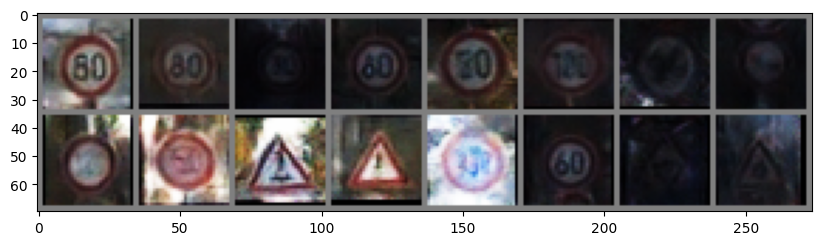

FID: 700.5744104501828
Epoch: 140, discrimiantor fake error: 0.329, discriminator real acc: 0.67
Epoch: 141, discrimiantor fake error: 0.33, discriminator real acc: 0.67
Epoch: 142, discrimiantor fake error: 0.327, discriminator real acc: 0.672
Epoch: 143, discrimiantor fake error: 0.328, discriminator real acc: 0.673
Epoch: 144, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 145, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 146, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 147, discrimiantor fake error: 0.329, discriminator real acc: 0.672
Epoch: 148, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 149, discrimiantor fake error: 0.327, discriminator real acc: 0.672


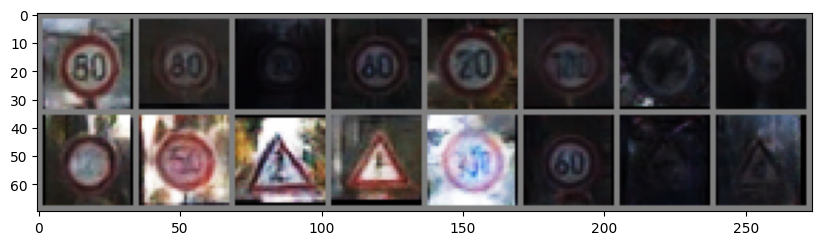

FID: 689.1532343789195
Epoch: 150, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 151, discrimiantor fake error: 0.327, discriminator real acc: 0.673
Epoch: 152, discrimiantor fake error: 0.328, discriminator real acc: 0.671
Epoch: 153, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 154, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 155, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 156, discrimiantor fake error: 0.329, discriminator real acc: 0.671
Epoch: 157, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 158, discrimiantor fake error: 0.327, discriminator real acc: 0.673
Epoch: 159, discrimiantor fake error: 0.328, discriminator real acc: 0.671


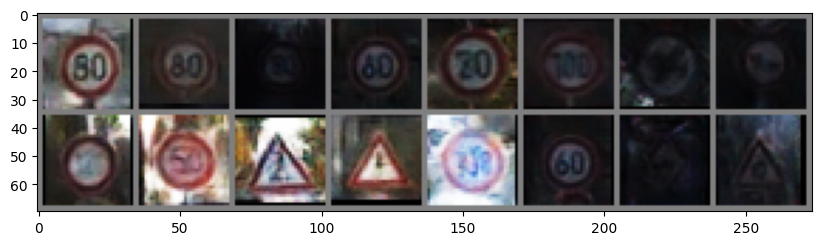

FID: 688.599525355271
Epoch: 160, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 161, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 162, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 163, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 164, discrimiantor fake error: 0.327, discriminator real acc: 0.673
Epoch: 165, discrimiantor fake error: 0.327, discriminator real acc: 0.673
Epoch: 166, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 167, discrimiantor fake error: 0.327, discriminator real acc: 0.672
Epoch: 168, discrimiantor fake error: 0.325, discriminator real acc: 0.675
Epoch: 169, discrimiantor fake error: 0.326, discriminator real acc: 0.673


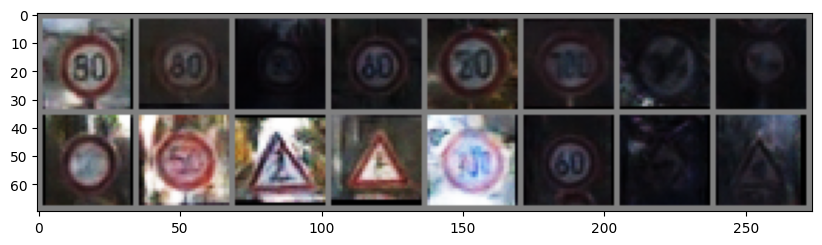

FID: 685.2934971944323
Epoch: 170, discrimiantor fake error: 0.327, discriminator real acc: 0.673
Epoch: 171, discrimiantor fake error: 0.327, discriminator real acc: 0.674
Epoch: 172, discrimiantor fake error: 0.327, discriminator real acc: 0.673
Epoch: 173, discrimiantor fake error: 0.326, discriminator real acc: 0.673
Epoch: 174, discrimiantor fake error: 0.328, discriminator real acc: 0.672
Epoch: 175, discrimiantor fake error: 0.324, discriminator real acc: 0.675
Epoch: 176, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 177, discrimiantor fake error: 0.327, discriminator real acc: 0.673
Epoch: 178, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 179, discrimiantor fake error: 0.326, discriminator real acc: 0.674


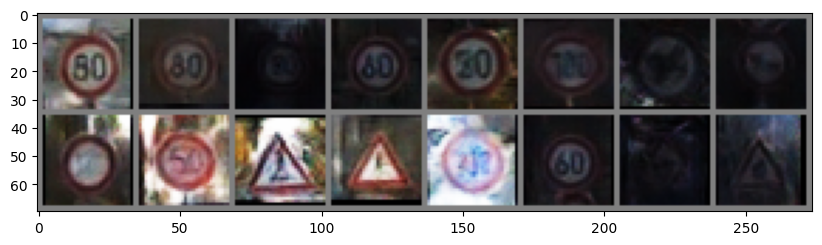

FID: 682.4058839699019
Epoch: 180, discrimiantor fake error: 0.325, discriminator real acc: 0.674
Epoch: 181, discrimiantor fake error: 0.325, discriminator real acc: 0.675
Epoch: 182, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 183, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 184, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 185, discrimiantor fake error: 0.325, discriminator real acc: 0.674
Epoch: 186, discrimiantor fake error: 0.326, discriminator real acc: 0.675
Epoch: 187, discrimiantor fake error: 0.324, discriminator real acc: 0.676
Epoch: 188, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 189, discrimiantor fake error: 0.325, discriminator real acc: 0.675


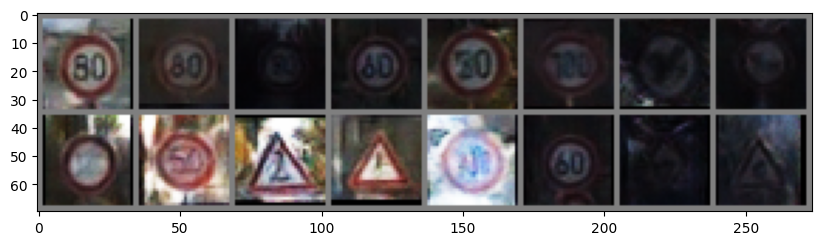

FID: 698.4111433822054
Epoch: 190, discrimiantor fake error: 0.325, discriminator real acc: 0.676
Epoch: 191, discrimiantor fake error: 0.324, discriminator real acc: 0.675
Epoch: 192, discrimiantor fake error: 0.324, discriminator real acc: 0.676
Epoch: 193, discrimiantor fake error: 0.324, discriminator real acc: 0.675
Epoch: 194, discrimiantor fake error: 0.324, discriminator real acc: 0.675
Epoch: 195, discrimiantor fake error: 0.323, discriminator real acc: 0.677
Epoch: 196, discrimiantor fake error: 0.326, discriminator real acc: 0.674
Epoch: 197, discrimiantor fake error: 0.324, discriminator real acc: 0.676
Epoch: 198, discrimiantor fake error: 0.325, discriminator real acc: 0.675
Epoch: 199, discrimiantor fake error: 0.324, discriminator real acc: 0.676


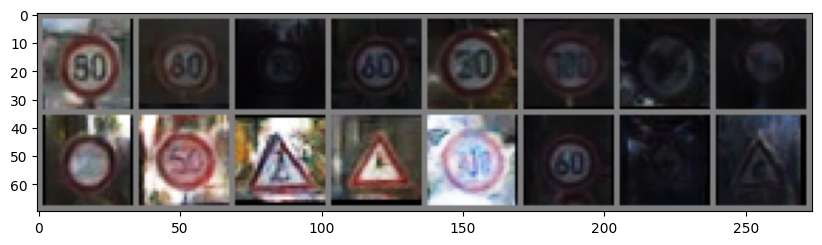

FID: 710.7276779944814


In [16]:
G_losses = []
D_losses = []
num_epochs = 200
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        # Discriminator
        ## All real
        discriminator_optimizer.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 0.9,  dtype=torch.float, device=device)
        output = discriminator(real_images).view(-1)
        error_discriminator_real = criterion(output, label)
        discriminator_real_acc.append(output.mean().item())

        ## All fake
        noise = torch.randn(b_size, latent_dim,device=device)
        fake_images = generator(noise)
        label_fake = torch.full((b_size,), 0.1,  dtype=torch.float, device=device)
        output = discriminator(fake_images.detach()).view(-1)
        error_discriminator_fake = criterion(output, label_fake)
        discriminator_fake_acc.append(output.mean().item())
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        discriminator_optimizer.step()

        # Generator
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)
        output = discriminator(fake_images).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 9:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()

        plt.figure(figsize=(10,10))
        imshow(torchvision.utils.make_grid(fake))

        with torch.no_grad():
            generations_gan = generator(eval_fixed_noise)
            dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

            fid = calculate_frechet_distance(dist_orig_data.numpy(),dist_gan.numpy())

        print(f"FID: {fid}")

        torch.save(generator.state_dict(), f'/content/drive/MyDrive/ssne/generator_weights(epoch_{epoch}_model_final2_fid_{fid:.0f}).pth')
        torch.save(discriminator.state_dict(), f'/content/drive/MyDrive/ssne/discriminator_weights(epoch_{epoch}_model_final2_fid_{fid:.0f}).pth')


In [ ]:
generator.load_state_dict(torch.load("/content/drive/MyDrive/ssne/generator_weights(epoch_199_model_final2_fid_711).pth"))
generator.eval()

discriminator.load_state_dict(torch.load("/content/drive/MyDrive/ssne/discriminator_weights(epoch_199_model_final2_fid_711).pth"))
discriminator.eval()

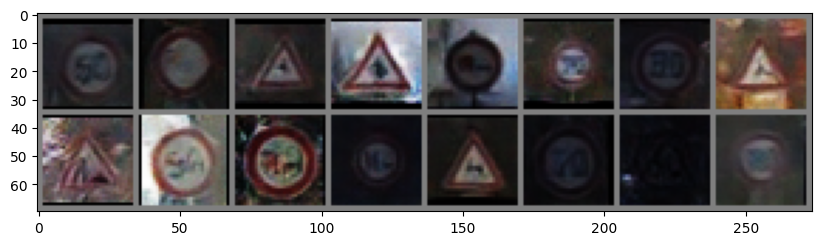

FID: 901.889911883989


In [34]:
fixed_noise = torch.randn(16, latent_dim,device=device)

eval_fixed_noise = torch.randn(1000, latent_dim,device=device)

with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()

plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(fake))

with torch.no_grad():
    generations_gan = generator(eval_fixed_noise)

    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

    fid = calculate_frechet_distance(dist_orig_data.numpy(),dist_gan.numpy())

print(f"FID: {fid}")

In [37]:
generations_gan = generations_gan * 0.5 + 0.5
generations_gan.shape

torch.Size([1000, 3, 32, 32])

In [38]:
torch.save(generations_gan.cpu().detach(),"/content/drive/MyDrive/ssne/generated.pt")